In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

## Aplicación 1: Comparar diferentes composiciones de portafolio

**Objetivo:** Analizar cómo cambian los rendimientos y el riesgo al modificar los pesos de los activos.

**Instrucciones:**

1. Definan tres combinaciones distintas de pesos entre los activos (ejemplo: Portafolio A = 70%/30%, Portafolio B = 50%/50%, Portafolio C = 20%/80%).

2. Simulen al menos 1,000 trayectorias de rendimientos para cada portafolio.

3. Calculen y comparen:

    * Rendimiento promedio.

    * Desviación estándar.

4. Construyan gráficos para cada portafolio:

    * Histogramas o boxplots de los rendimientos simulados.

    * Un cuadro comparativo con medias y desviaciones estándar.

5. Redacten una breve conclusión indicando qué portafolio resulta más riesgoso y cuál se percibe más atractivo.

### Activos Seleccionados
* NVDA
* Oracle

### Indicaciones
* 30 días
* 1,000 simulaciones

In [3]:
tickers = ['NVDA', 'ORCL']
start = '2020-01-01'
end = '2025-09-24'
num_dias = 30
num_simulaciones = 1000

In [4]:
def simulacion_portafolio(tickers: list, start: str, end: str, w, num_dias, num_simulaciones):

  # Descargar los precios de los tickers
  prices = yf.download(tickers, start=start, end=end)['Close']

  # Calcular los rendimientos diarios
  returns = prices.pct_change().dropna()

  # rendimiento promedio
  mu = returns.mean().values

  # Covarianza
  cov = returns.cov().values

  # Definimos w como un array
  w = np.array(w)

  # Matriz para contener los rendimientos del portafolio
  p_returns = np.full(shape = (num_simulaciones, num_dias), fill_value = 0.0)
  for i in range(num_simulaciones):
    L = np.linalg.cholesky(cov)
    Z = np.random.normal(0, 1, (num_dias, len(w)))
    daily_returns = np.array(mu) + Z @ L.T

    daily_p_returns = daily_returns @ w
    cumulative_returns = np.cumprod(1 + daily_p_returns)
    p_returns[i, :] = cumulative_returns

  return p_returns

### Primer Peso

In [5]:
p_returns = simulacion_portafolio(tickers, start, end, [0.7, 0.3], num_dias, num_simulaciones)
sim_returns = p_returns[:, -1] - 1

# Rendimiento Promedio
peso_1_mean  = sim_returns.mean()
print(f'Rendimiento Promedio: {sim_returns.mean():.2%}')

[*********************100%***********************]  2 of 2 completed

Rendimiento Promedio: 8.29%


In [6]:
# Desviación estandar
peso_1_std  = sim_returns.std()
print(f'Desviación Estandar: {sim_returns.std():.2%}')

Desviación Estandar: 17.09%


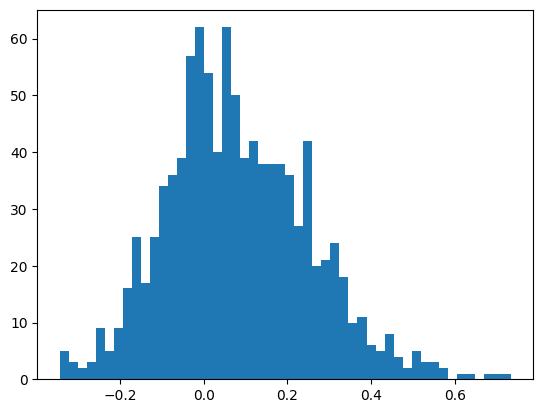

In [7]:
# histograma de rendimientos
plt.hist(sim_returns, bins=50)
plt.show()

### Segundo Peso

In [8]:
p_returns_2 = simulacion_portafolio(tickers, start, end, [0.5, 0.5], num_dias, num_simulaciones)
sim_returns_2 = p_returns_2[:, -1] - 1

[*********************100%***********************]  2 of 2 completed


In [9]:
peso_2_mean  = sim_returns_2.mean()
print(f'Rendimiento Promedio: {sim_returns.mean():.2%}')

Rendimiento Promedio: 8.29%


In [10]:
peso_2_std  = sim_returns_2.std()
print(f'Desviación Estandar: {sim_returns.std():.2%}')

Desviación Estandar: 17.09%


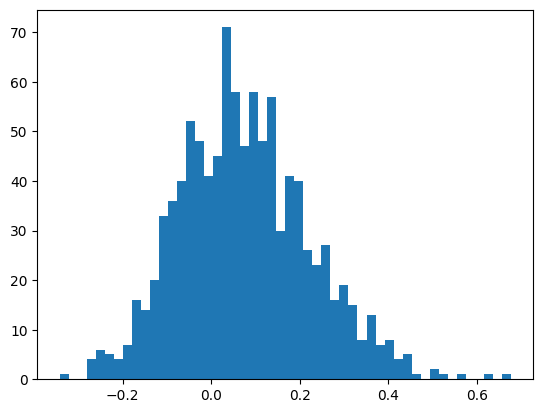

In [11]:
plt.hist(sim_returns_2, bins=50)
plt.show()

### Tercer Peso

In [12]:
p_returns_3 = simulacion_portafolio(tickers, start, end, [0.2, 0.8], num_dias, num_simulaciones)
sim_returns_3 = p_returns_3[:, -1] - 1

[*********************100%***********************]  2 of 2 completed


In [13]:
peso_3_mean  = sim_returns_3.mean()
print(f'Rendimiento Promedio: {sim_returns.mean():.2%}')

Rendimiento Promedio: 8.29%


In [14]:
peso_3_std  = sim_returns_3.std()
print(f'Desviación Estandar: {sim_returns.std():.2%}')

Desviación Estandar: 17.09%


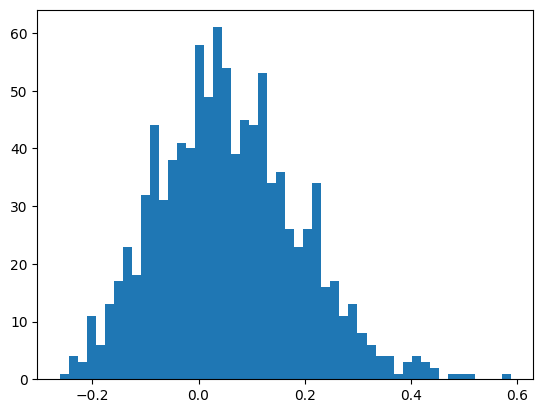

In [15]:
plt.hist(sim_returns_3, bins=50)
plt.show()

### Tabla Comparativa

In [16]:
# tabla comparativa de desviaciones y medias
pd.DataFrame({'Peso 1': [peso_1_mean, peso_1_std], 'Peso 2': [peso_2_mean, peso_2_std], 'Peso 3': [peso_3_mean, peso_3_std]}, index=['Rendimiento Promedio', 'Desviación Estandar'])

,Peso 1,Peso 2,Peso 3
Rendimiento Promedio,0.082938,0.075839,0.057674
Desviación Estandar,0.170867,0.147178,0.132749


## Aplicación 2: Estimación de métricas de riesgo
**Objetivo:** Cuantificar el riesgo de un portafolio a partir de las simulaciones.

**Instrucciones:**

1. Seleccionen un portafolio (puede ser uno de la Aplicación 1). 

2. A partir de sus simulaciones, calculen:

- Probabilidad de pérdida: P(r < 0).

- Valor en Riesgo (VaR) al 95% y al 99%.

- Expected Shortfall (o CVaR) al 95%.

3. Representen los resultados gráficamente:

- Histograma de los rendimientos simulados, señalando las zonas correspondientes al VaR.

- Una tabla con las métricas obtenidas.

4. Interpreten los resultados:

- ¿Qué tan probable es perder dinero?

- ¿Qué tan graves pueden ser las pérdidas en los peores escenarios? 

In [17]:
# Función para descargar datos de yfinance y calcular mu y sigma
def get_data_portafolio(ticker, start, end):
    prices = yf.download(ticker, start=start, end=end, progress=False)['Close']
    returns = prices.pct_change().dropna()
    mu = returns.mean()
    cov = returns.cov()
    return prices, mu, cov

def simular_precios_portafolio(num_simulaciones, w, mu, cov, num_dias):

    # Matriz para contener los rendimientos del portafolio
    p_returns = np.full(shape = (num_simulaciones, num_dias), fill_value = 0.0)

    for i in range(num_simulaciones):
        L = np.linalg.cholesky(cov)
        Z = np.random.normal(0, 1, (num_dias, len(w)))
        daily_returns = np.array(mu) + Z @ L.T

        daily_p_returns = daily_returns @ w
        cumulative_returns = np.cumprod(1 + daily_p_returns)
        p_returns[i, :] = cumulative_returns

    return p_returns

In [18]:
num_simulaciones = 100000
num_dias = 30

tickers = ['NVDA', 'ORCL']
w = [0.5, 0.5]

prices, mu, cov = get_data_portafolio(tickers, dt.datetime.now() - dt.timedelta(days=365 * 4), dt.datetime.now())

p_returns = simular_precios_portafolio(num_simulaciones, w, mu, cov, num_dias)

In [19]:
# Precio inicial del portafolio
f_price = np.dot(np.array(prices.tail(1)), w)[0]

# Precios finales simulados del portafolio
sim_final_prices = p_returns[:, -1] * f_price

In [20]:
# Probabilidad de pérdida
prob_perdidas = sum(sim_final_prices < f_price) / num_simulaciones
prob_perdidas

np.float64(0.34659)

In [21]:
# Cálculo de pérdida máxima esperada (VaR) al 95% y 99%
Var_95 = np.percentile(sim_final_prices, 5)
Var_99 = np.percentile(sim_final_prices, 1)

Var_95 - f_price, Var_99 - f_price

(np.float64(-37.54973179176753), np.float64(-55.55948995421099))

In [22]:
# Cálculo de CVaR al 95%
CVar_95 = np.mean([i for i in sim_final_prices if i <= Var_95])

CVar_95 - f_price

np.float64(-48.52701623858499)

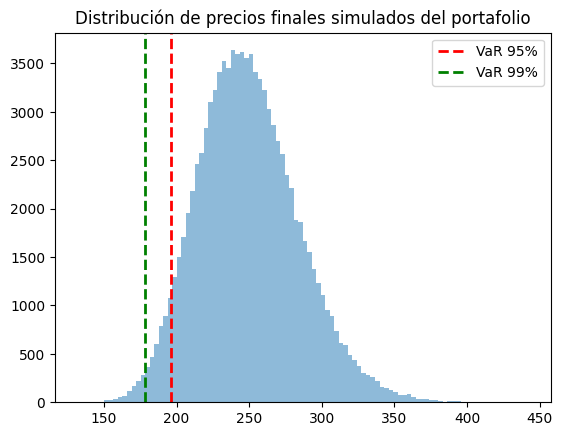

In [23]:
plt.hist(sim_final_prices, bins=100, alpha = 0.5)
plt.axvline(Var_95, color='r', linestyle='dashed', linewidth=2, label='VaR 95%')
plt.axvline(Var_99, color='g', linestyle='dashed', linewidth=2, label='VaR 99%')
plt.title('Distribución de precios finales simulados del portafolio')
plt.legend()
plt.show()

In [24]:
Resultados = pd.DataFrame({
    'Métrica': ['Valor inicial', 'Valor Final Esperado', 'Rendimiento Esperado %', 'Prob de Pérdidas %', 'VaR 95', 'VaR 99', 'CVaR 95'],
    'Valor': [f_price, sim_final_prices.mean(), (sim_final_prices.mean() - f_price) * 100 / f_price, prob_perdidas *100, Var_95, Var_99, CVar_95]
})

Resultados

,Métrica,Valor
0,Valor inicial,233.909996
1,Valor Final Esperado,249.488659
2,Rendimiento Esperado %,6.660110
3,Prob de Pérdidas %,34.659000
4,VaR 95,196.360264
5,VaR 99,178.350506
6,CVaR 95,185.382980


## Aplicación 3: Escenarios macroeconómicos

Objetivo: Explorar cómo cambia el comportamiento del portafolio bajo distintos contextos económicos.

Instrucciones:

1. Definan tres escenarios:

   - Alcista: aumentar la media de los rendimientos en +0.001.

   - Bajista: disminuir la media en –0.001.

   - Base: usar los rendimientos originales.

2. Simulen al menos 10,000 trayectorias para cada escenario.

3. Construyan comparaciones gráficas:

   - Histogramas de las distribuciones en los tres escenarios.

   - Gráfico comparativo de medias y desviaciones estándar entre escenarios.

4. Analicen:

   - ¿En qué escenario la probabilidad de pérdida es mayor?

   - ¿Cuál presenta mayor dispersión de resultados?

In [25]:
def get_data(tickers, start, end):
    prices = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    returns = prices.pct_change().dropna()
    mu = returns.mean()        
    sigma = returns.std()      
    matriz_cov = returns.cov() 
    return prices, mu, sigma, matriz_cov


def simular_precios(num_simulaciones, weights, mu, matriz_cov, prices, num_dias):
    weights = np.array(weights) / np.sum(weights)
    mu_v = np.array(mu)
    cov = np.array(matriz_cov)
    n_assets = len(mu_v)

    initial_prices = np.array(prices.iloc[-1])

    # Cholesky
    L = np.linalg.cholesky(cov + 1e-10 * np.eye(n_assets))

    portfolio_final = np.zeros(num_simulaciones)

    for i in range(num_simulaciones):
        Z = np.random.normal(size=(n_assets, num_dias))
        correlated_shocks = L @ Z
        daily_returns = mu_v.reshape(-1,1) + correlated_shocks
        price_paths = initial_prices.reshape(-1,1) * np.cumprod(1 + daily_returns, axis=1)
        portfolio_prices = weights @ price_paths
        portfolio_final[i] = portfolio_prices[-1]  # valor final

    return portfolio_final

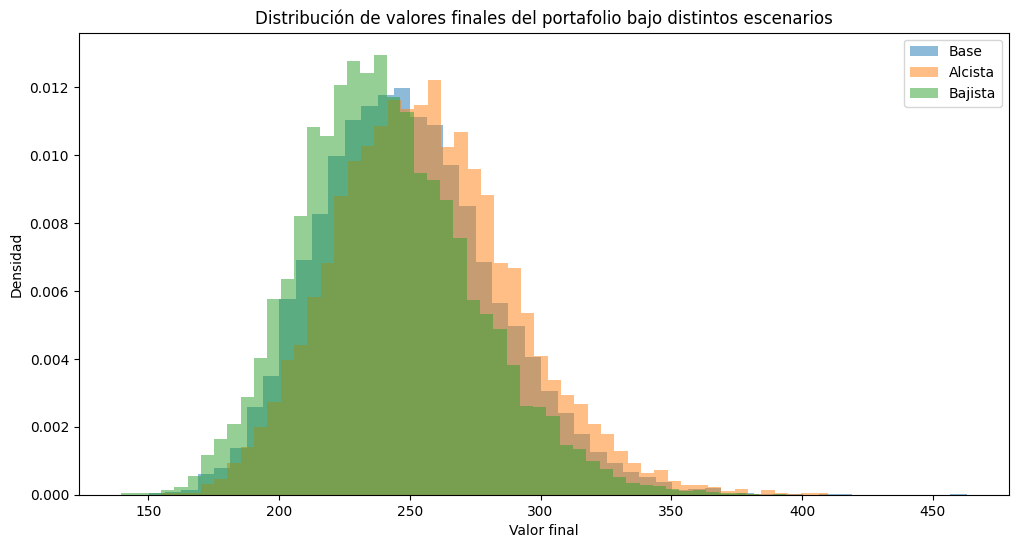

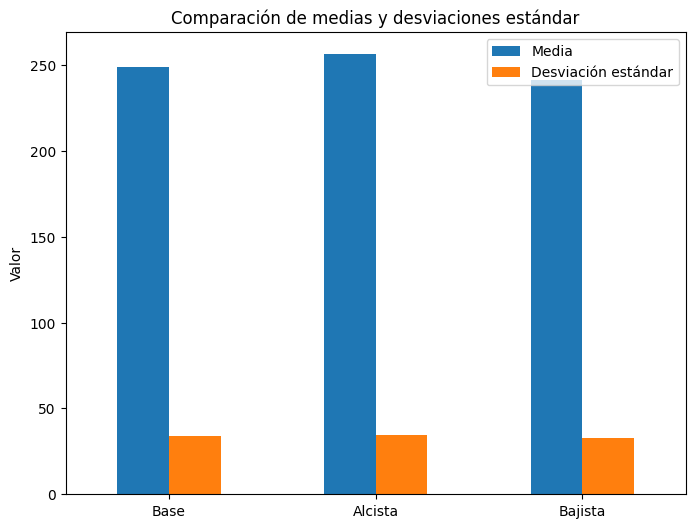

 Estadísticas por escenario:
              Media  Desviación estándar
Base     249.097435            33.820331
Alcista  256.276335            34.426934
Bajista  241.489799            32.969939
Escenario Base: Probabilidad de pérdida = 34.73%
Escenario Alcista: Probabilidad de pérdida = 26.75%
Escenario Bajista: Probabilidad de pérdida = 43.82%


In [26]:
stocks = ["ORCL", "NVDA"]
weights = [0.5, 0.5]
num_simulaciones = 10000
num_dias = 30  

start = dt.datetime.now() - dt.timedelta(days=365*4)
end = dt.datetime.now()

prices, mu, sigma, matriz_cov = get_data(stocks, start, end)

escenarios = {
    "Base": mu,
    "Alcista": mu + 0.001,
    "Bajista": mu - 0.001
}

resultados = {}
for nombre, mu_esc in escenarios.items():
    resultados[nombre] = simular_precios(num_simulaciones, weights, mu_esc, matriz_cov, prices, num_dias)


# Histogramas
plt.figure(figsize=(12,6))
for nombre, data in resultados.items():
    plt.hist(data, bins=50, alpha=0.5, density=True, label=nombre)
plt.legend()
plt.title("Distribución de valores finales del portafolio bajo distintos escenarios")
plt.xlabel("Valor final")
plt.ylabel("Densidad")
plt.show()

# Medias y desviaciones
estadisticas = pd.DataFrame({
    "Media": {k: np.mean(v) for k,v in resultados.items()},
    "Desviación estándar": {k: np.std(v) for k,v in resultados.items()}
})

estadisticas.plot(kind="bar", figsize=(8,6))
plt.title("Comparación de medias y desviaciones estándar")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.show()

print(" Estadísticas por escenario:")
print(estadisticas)

for nombre, data in resultados.items():
    prob_perdida = np.mean(data < prices.iloc[-1].dot(weights))
    print(f"Escenario {nombre}: Probabilidad de pérdida = {prob_perdida:.2%}")